In [3]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'

In [5]:
def mesher2D(nrows,ncols,length,height,deg=1):
    '''
    This is a function for creating a mesh of 2D rectilinear elements. It assumes the points are laid out in a grid.
    Currently, only linear elements are supported.

    Inputs
    ------
    nrows: integer. Number of elements in a row
    ncols: integer. Number of elements in a column
    length: float. Length of the domain
    height: float. Height of the domain

    Returns
    -------
    node_dict: dictionary. A multi-level dictionary with the global node numbers as the outer keys, and the inner dictionary
    for each global node containing the x and y coordinates of that node.
    
    elem_nodes: array. An array where each row is an element, counting left to right, bottom to top of the domain,
    and each entry for each element are the global node numbers, counting counter-clockwise from the upper right node.

    '''
    if nrows*ncols%2 != 0:
        root = np.sqrt(nrows*ncols)
        if root - int(root) > 0.0: # checks for a perfect square
            raise ValueError('Uneven grid detected.')
        # else:
        #     print('Square domain detected.')
    n_xnodes = ncols + 1
    n_ynodes = nrows + 1
    dx = length/ncols
    dy = height/nrows
    xnodes = np.arange(0,length+dx,dx)
    ynodes = np.arange(0,height+dy,dy)
    X,Y = np.meshgrid(xnodes,ynodes)
    if deg==1:
        nodes_per_elem=4
    elem_nodes = np.zeros((nrows*ncols,nodes_per_elem),dtype='int')
    # row = 0
    # for e in range(nrows*ncols):
    #     # print(e+row,e+1+row,e+nrows+1+row,e+nrows+2+row)
    #     elem_nodes[e] = e+nrows+2+row,e+nrows+1+row,e+row,e+1+row
    #     if (e%(ncols-1) == 0.0 and e!=0):
    #         row += 1
    for row in range(nrows):
        for col in range(ncols):
            elem_nodes[nrows*row+col] = n_xnodes*(row+1)+(col+1),n_xnodes*(row+1)+col,n_xnodes*row+col,n_xnodes*row+col+1
    node_dict = {}
    node_count = 0
    for i in range(nrows+1):
        for j in range(ncols+1):
            node_dict[node_count] = {'x':X[i,j],'y':Y[i,j]}
            node_count += 1
    return node_dict, elem_nodes

def retrieve_coords(node_dict,elem_nodes,eid):
    nodes = elem_nodes[eid]
    x = []
    y = []
    for node in nodes:
        xval = node_dict[node]['x']
        yval = node_dict[node]['y']
        x.append(xval)
        y.append(yval)
    coords = np.concatenate((x,y))
    return coords

def create_bcs(nrows,ncols):
    nnodes = 2*nrows*ncols+1
    nx = nrows + 1
    ny = ncols + 1
  
    mesh = np.zeros((ny,nx))
    mesh[:,0] = 1
    mesh[0,1:] = 2
    mesh[-1,1:] = 2
    mesh[:,-1] = 2
    mesh[0,0] = 3
    mesh[-1,0] = 3
 
    return mesh

def square_basis(coords):
    x = coords[:len(coords)//2]
    y = coords[len(coords)//2:]

    x_ = np.linspace(x.min(),x.max())
    y_ = np.linspace(y.min(),y.max())
    X,Y = np.meshgrid(x_,y_)
    
    N1 = (X-x[1])/(x[0]-x[1])*(Y-y[3])/(y[0]-y[3])
    N2 = (X-x[0])/(x[1]-x[0])*(Y-y[2])/(y[1]-y[2])
    N3 = (X-x[3])/(x[2]-x[3])*(Y-y[1])/(y[2]-y[1])
    N4 = (X-x[2])/(x[3]-x[2])*(Y-y[0])/(y[3]-y[0])
    return [N1,N2,N3,N4]

def sq_basis_derivs(coords):
    x = coords[:len(coords)//2]
    y = coords[len(coords)//2:]
    a = (x.max()-x.min())/2
    b = (y.max()-y.min())/2
    x_ = np.linspace(x.max(),x.min())
    y_ = np.linspace(y.max(),y.min())
    X,Y = np.meshgrid(x_,y_)
    dN1dx = 1/(x[0]-x[1])*(Y-y[3])/(y[0]-y[3])
    dN1dy = (X-x[1])/(x[0]-x[1])*1/(y[0]-y[3])
    dN2dx = 1/(x[1]-x[0])*(Y-y[2])/(y[1]-y[2])
    dN2dy = (X-x[0])/(x[1]-x[0])*1/(y[1]-y[2])
    dN3dx = 1/(x[2]-x[3])*(Y-y[1])/(y[2]-y[1])
    dN3dy = (X-x[3])/(x[2]-x[3])*1/(y[2]-y[1])
    dN4dx = 1/(x[3]-x[2])*(Y-y[0])/(y[3]-y[0])
    dN4dy = (X-x[2])/(x[3]-x[2])*1/(y[3]-y[0])
    return [dN1dx,dN2dx,dN3dx,dN4dx], [dN1dy,dN2dy,dN3dy,dN4dy]

def globalK(elem_nodes,eid,k,K):
    nodes = elem_nodes[eid]
    rows,cols = k.shape
    nodes_rows = int(np.sqrt(len(nodes)))
    nodes.reshape(nodes_rows,nodes_rows)
    for row in range(rows):
        for col in range(cols):
            K[nodes[row],nodes[col]] += k[row,col]
    return K

def globalF(elem_nodes,eid,f,F):
    nodes = elem_nodes[eid]
    rows = len(f)
    for row in range(rows):
        F[nodes[row]] += f[row]
    return F

def cond_mat(dNdxi,dNdeta,k,J=None):
    # J defaults to none for non-isoparametric reference elements
    K1 = np.concatenate((dNdxi[0],dNdeta[0]),axis=1)
    K2 = np.concatenate((dNdxi[0],dNdeta[0]),axis=0)
    if J is not None:
        Jinv = np.linalg.inv(J)
    # dNdxi_col = np.array(dNdxi).reshape(-1,1)
    # dNdxi_row = np.array(dNdxi).reshape(1,-1)
    # dNdeta_col = np.array(dNdeta).reshape(-1,1)
    # dNdeta_row = np.array(dNdeta).reshape(1,-1)
    for dNx, dNe in zip(dNdxi[1:],dNdeta[1:]):
        k1 = np.concatenate((dNx,dNe),axis=1)
        k2 = np.concatenate((dNx,dNe),axis=0)
        K1 = np.concatenate((K1,k1),axis=0)
        K2 = np.concatenate((K2,k2),axis=1)
    if J==None:
        Kint = k*K1@K2
    else:
        Kint = k*np.linalg.det(J)*(K1@Jinv.T@Jinv@K1.T)
    return Kint
    
def conv_mat(N,hz,lin=True):
    if lin:
        n = 4
    rows, cols = N[0].shape
    Kint = np.zeros((n*rows,n*cols))
    for row in range(n):
        for col in range(n):
            Kint[row*rows:row*rows+rows,col*cols:col*cols+cols] = hz*N[row]*N[col]
    return Kint

def rhs_vec(N,hz,k,Tinf,coords,bcs_arr,elem_nodes,eid,qtop,qbot,qright):
    '''
    Linear rectilinear elements only currently.
    Boundary conditions will also be treated here.
    '''
    nodes = elem_nodes[eid]
    x = coords[:len(coords)//2]
    y = coords[len(coords)//2:]
    rows,cols = N[0].shape
    x1 = x.min()
    x2 = x.max()
    y1 = y.min()
    y2 = y.max()
    x_ = np.linspace(x1,x2,rows)
    y_ = np.linspace(y1,y2,cols)
    F = np.zeros(4)

    ### BOUNDARY CONDITIONS ###
    # 1D shape functions for treating boundary conditions
    N1x = (x_-x1)/(x2-x1)
    N2x = (x_-x2)/(x1-x2)
    N1y = (y_-y1)/(y2-y1)
    N2y = (y_-y2)/(y1-y2)
    for i in range(4):
        Z = hz*Tinf*N[i]
        xint = np.trapz(Z,x=x_,axis=1)
        integrand = np.trapz(xint,x=y_)
        F[i] += integrand

    bcs_arr = bcs_arr.flatten()
    # Case 1: Top boundary
    if (bcs_arr[nodes[0]] and bcs_arr[nodes[1]]) >= 2:
        q = qtop*N1x
        xint = np.trapz(q,x=x_)
        F[0] += xint
        q = qtop*N2x
        xint = np.trapz(q,x=x_)
        F[1] += xint
    # Case 2: Bottom boundary
    if (bcs_arr[nodes[2]] and bcs_arr[nodes[3]]) >= 2:
        q = qbot*N2x
        xint = np.trapz(q,x=x_)
        F[2] += xint
        q = qbot*N1x
        xint = np.trapz(q,x=x_)
        F[3] += xint    
    # Case 3: Right boundary
    if (bcs_arr[nodes[3]] and bcs_arr[nodes[0]]) >= 2:
        q = qright*N2y
        yint = np.trapz(q,x=y_)
        F[3] += yint
        q = qright*N1y
        yint = np.trapz(q,x=y_)
        F[0] += yint
    return F

def integrateK(K,coords):
    '''
    Linear rectilinear elements only currently
    '''
    x = coords[:len(coords)//2]
    y = coords[len(coords)//2:]
    rows,cols = K.shape
    nx = rows//4
    x1 = x.min()
    x2 = x.max()
    y1 = y.min()
    y2 = y.max()
    x_ = np.linspace(x1,x2,nx)
    y_ = np.linspace(y1,y2,nx)
    Kint = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            xint = np.trapz(K[i*nx:i*nx+nx,j*nx:j*nx+nx],x=x_,axis=1)
            integrand = np.trapz(xint,x=y_)
            Kint[i,j] = integrand
    return Kint


In [6]:
nelemsx = 50
nelemsy = 50
nnodes = (nelemsx+1)*(nelemsy+1)
L = 2.
H = 2.
x = np.linspace(0,L,nelemsx+1)
y = np.linspace(0,H,nelemsy+1)
X,Y = np.meshgrid(x,y)
t = 0.05
Twall = 80.
Tinf = 30.
kcond = 5.
hconv = 10.
qtop = -500.
qright = -1000.
qbot = -1500.
hz = 2*hconv/t
node_dict, elem_nodes = mesher2D(nelemsy,nelemsx,L,H,1)
K = np.zeros((nnodes,nnodes))
F = np.zeros(nnodes)

In [7]:
for eid in range(nelemsx*nelemsy):
    coords = retrieve_coords(node_dict,elem_nodes,eid)
    bcs_arr = create_bcs(nelemsy,nelemsx)
    N = square_basis(coords)
    dNx,dNy = sq_basis_derivs(coords)
    k1 = cond_mat(dNx,dNy,kcond,None)
    k2 = conv_mat(N,hz,True)
    kint = integrateK(k1+k2,coords)
    K = globalK(elem_nodes,eid,kint,K)
    # print(K)
    # print('*'*20)
    fint = rhs_vec(N,hz,kcond,Tinf,coords,bcs_arr,elem_nodes,eid,qtop,qbot,qright)
    F = globalF(elem_nodes,eid,fint,F)
    # print(F)
for idx,bcs in enumerate(bcs_arr.flatten()):
    if (bcs == 1 or bcs == 3):
        K[idx,idx] = 1e10
        F[idx] = Twall*1e10

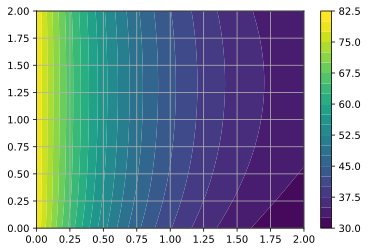

In [8]:
T = np.linalg.solve(K,F)
i = int(np.sqrt(len(T)))
plt.contourf(X,Y,T.reshape(i,i),vmin=30,vmax=80,levels=20)
plt.grid()
plt.colorbar()

In [18]:
K

array([[ 1.00000000e+10,  2.22175926e+01,  0.00000000e+00,
         2.22175926e+01, -1.13898142e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.22175926e+01,  3.38925914e+02,  2.22175926e+01,
        -1.13898142e+02,  4.44351852e+01, -1.13898142e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.22175926e+01,  1.69462957e+02,
         0.00000000e+00, -1.13898142e+02,  2.22175926e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.22175926e+01, -1.13898142e+02,  0.00000000e+00,
         1.00000000e+10,  4.44351852e+01,  0.00000000e+00,
         2.22175926e+01, -1.13898142e+02,  0.00000000e+00],
       [-1.13898142e+02,  4.44351852e+01, -1.13898142e+02,
         4.44351852e+01,  6.77851829e+02,  4.44351852e+01,
        -1.13898142e+02,  4.44351852e+01, -1.13898142e+02],
       [ 0.00000000e+00, -1.13898142e+02,  2.22175926e+01,
         0.00000000e+00,  4.44351852e+01,  3.389259

In [29]:
f = lambda x: x**2

In [35]:
np.trapz(f(x),x=x)

0.6672219908371511

In [36]:
f(x1)+f(x2)

0.6666666666666666